<h1>NYC Taxi Duration Analysis<h1>

The NYC Taxi Duration dataset was used as a Kaggle competition in the past. I want to use this as practice on a dataset with a large amount of data (over 1 million records)

<h2>Problem Statements and Questions<h2>

In NYC, Taxi travel is one of the few forms of public transportation, including subways, uber, and systems like citibike. The main objective of this challenge is to estimate the duration of a taxi trip based on geographical data such as the pickup and drop off location, time of day, day of week, and weather conditions. Here are some other questions that we aim to answer by the end of the project: 
1. What are the average, median, and distribution of taxi trip durations in NYC? 
1. How do trip durations vary by time of day? 
1. Which factors (e.g., pickup location, dropoff location, time of day, day of the week) are most predictive of taxi trip duration?
1. How does the duration of trips to and from airports (e.g., JFK, LaGuardia) compare to other trips?
1. What are the most common routes taken by taxis, and how do their durations compare?
1. How does inclement weather (e.g., heavy rain, snowstorms) affect taxi trip duration?
1. Are there any significant differences in trip duration across different boroughs of NYC (e.g., Manhattan vs. Brooklyn)?
1. How does the introduction of bike lanes or pedestrian zones impact taxi trip durations in certain areas?
1. What are the longest and shortest taxi trips recorded, and what are their characteristics?
1. How does traffic congestion data correlate with taxi trip durations?
1. Can we identify any trends or patterns in trip durations over the years (e.g., before and after the implementation of ride-sharing services)?
1. How do taxi trip durations change during major city events (e.g., New Year’s Eve, marathons, parades)?
1. What are the peak hours for long vs. short taxi trips?
1. How do fare structures (e.g., flat rate vs. metered rate) impact trip duration?
1. Can we build a real-time prediction model to estimate the duration of a taxi trip as it progresses, using live data inputs?


## Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from pyspark.sql import SparkSession

# Part 1: Data Ingestion

In [2]:
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/10 16:34:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [25]:
data_path = "./data/train.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show(5)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

# Part 2: EDA and Data Analysis

Before we do any modeling and data transformation (adding variables and such, we can do some analysis on the base dataset itself)

1. What are the average, median, and range of taxi trip durations?
1. What is the distribution of taxi trip durations? Are there any outliers?
1. What is the average number of passengers per trip?

Temporal Analysis:
1. How do trip durations vary by time of day (e.g., morning vs. evening)?
1. How do trip durations vary by day of the week?
1. Are there any seasonal trends in trip durations?
1. What are the peak hours for taxi pickups and dropoffs?
1. How does the trip count vary by month?


Spatial Analysis:
1. What are the most common pickup and dropoff locations?
1. How do trip durations vary by pickup and dropoff locations?
1. What is the average trip distance, and how does it correlate with trip duration?
1. Which areas have the highest concentration of taxi activity?


Passenger Analysis:
1. How does the number of passengers affect trip duration?
1. What is the distribution of trips by passenger count?


First check for missing values

In [26]:
for col in df.columns: 
    print(f"Number of missing values in {col}: {df.filter(df[col].isNull()).count()}")

Number of missing values in id: 0
Number of missing values in vendor_id: 0


Number of missing values in pickup_datetime: 0


Number of missing values in dropoff_datetime: 0
Number of missing values in passenger_count: 0
Number of missing values in pickup_longitude: 0
Number of missing values in pickup_latitude: 0


Number of missing values in dropoff_longitude: 0
Number of missing values in dropoff_latitude: 0
Number of missing values in store_and_fwd_flag: 0
Number of missing values in trip_duration: 0


No missing values. Check the description of the columns + types

In [5]:
df.columns

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration']

In [6]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



<h2>Column Descriptions<h2>

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds


In [7]:
df.describe().show()

24/07/10 16:39:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|summary|       id|          vendor_id|   passenger_count|   pickup_longitude|     pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|     trip_duration|
+-------+---------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|  count|  1458644|            1458644|           1458644|            1458644|             1458644|            1458644|            1458644|           1458644|           1458644|
|   mean|     NULL| 1.5349502688798637|1.6645295219395548| -73.97348630489282|  40.750920908391734|  -73.9734159469458|   40.7517995149002|              NULL| 959.4922729603659|
| stddev|     NULL|0.49877715390740074| 1.314242167823115|0.07090185842270368|0.032881186257633095|0.070643268

## Data Transformation 

We probably need to add a few extra columns. The first thing we're going to do however is split the time, date, and add a day of the week variable in the df

In [27]:
from pyspark.sql.functions import to_date, date_format
df = df.withColumn("pickup_date", to_date(df.pickup_datetime)) \
    .withColumn("dropoff_date", to_date(df.dropoff_datetime)) \
    .withColumn("pickup_time", date_format(df.pickup_datetime, "HH:mm:ss")) \
        .withColumn("dropoff_time", date_format(df.dropoff_datetime, "HH:mm:ss")) \
            .withColumn("pickup_day_of_week", date_format(df.pickup_datetime, "E")) \
                .withColumn("dropoff_day_of_week", date_format(df.dropoff_datetime, "E"))
df = df.drop("pickup_datetime", "dropoff_datetime")

Let's also encode the store and fwd flag as 1s and 0s instead of Y and N

In [ ]:
from pyspark.sql.functions import when, col

df = df.withColumn("store_and_fwd_flag", when(col("store_and_fwd_flag") == "N", 0).otherwise(1))

In [28]:
df.show(5)

+---------+---------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-----------+------------+-----------+------------+------------------+-------------------+
|       id|vendor_id|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|pickup_date|dropoff_date|pickup_time|dropoff_time|pickup_day_of_week|dropoff_day_of_week|
+---------+---------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-----------+------------+-----------+------------+------------------+-------------------+
|id2875421|        2|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455| 2016-03-14|  2016-03-14|   17:24:55|    17:32:30|               Mon|                Mon|
|id2377394|        1|              1|-73.98041534423828|

For the sake of plotting, we need to convert our data to pandas. And also since there are so many records, we will use a representative sample of ~100k records

In [8]:
df_sample = df.sample(0.1, seed=42)
pdf = df_sample.toPandas()

## trip_duration Analysis

Since eventually we want to predict trip_duration, we should probably take a look at that variable first

In [10]:
print(f"The mean of the target variable is: {pdf['trip_duration'].mean()} seconds")
print(f"The median of the target variable is: {pdf['trip_duration'].median()} seconds")
print(f"The standard deviation of the target variable is: {pdf['trip_duration'].std()} seconds")

The mean of the target variable is: 961.1490736928778 seconds
The median of the target variable is: 662.0 seconds
The standard deviation of the target variable is: 3269.2974780537184 seconds


There seems to be a really wide standard deviation for the target variable. Let's visualize

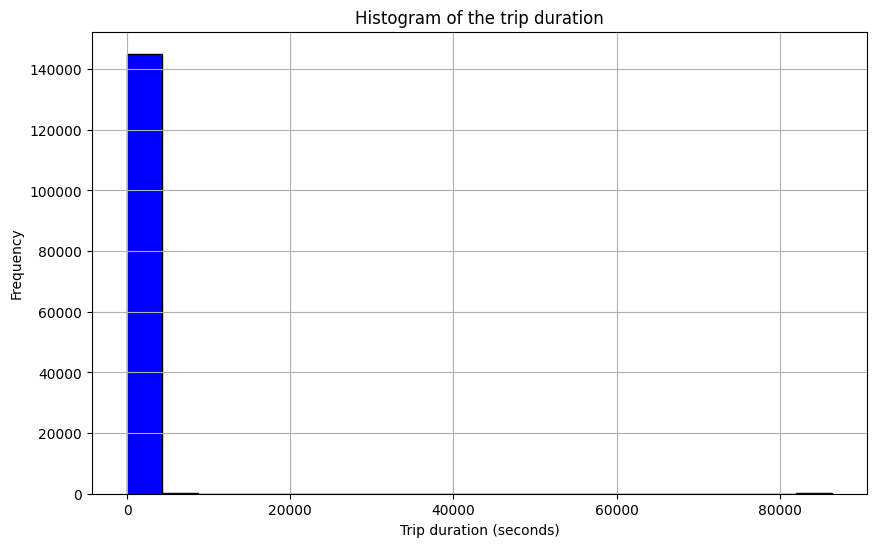

In [11]:
plt.figure(figsize=(10,6))
plt.hist(pdf['trip_duration'], bins=20, color='blue', edgecolor='black')
plt.title("Histogram of the trip duration")
plt.xlabel("Trip duration (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


There are some heavy right skew, so let us take log of the trip duration

In [12]:
pdf['trip_duration_log'] = np.log(pdf['trip_duration'] + 1)

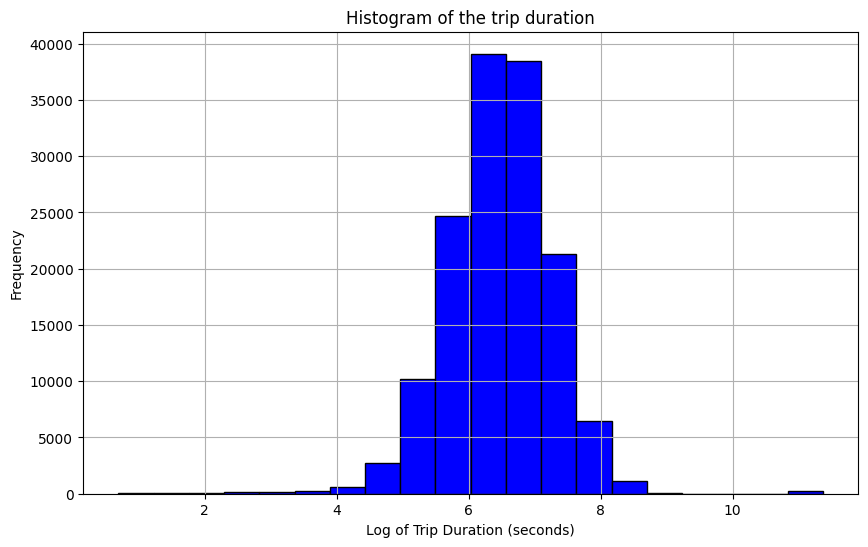

In [13]:
plt.figure(figsize=(10,6))
plt.hist(pdf['trip_duration_log'], bins=20, color='blue', edgecolor='black')
plt.title("Histogram of the trip duration")
plt.xlabel("Log of Trip Duration (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We could get rid of outliers within a certain range when data processing. Log processing seems to do much better

### passengers

In [18]:
print(f"The min and max of the number of passengers is: {pdf['passenger_count'].min()} and {pdf['passenger_count'].max()}")

The min and max of the number of passengers is: 0 and 6


In [14]:
print(f"The average number of passengers is {pdf['passenger_count'].mean()}")

The average number of passengers is 1.6575888568683959


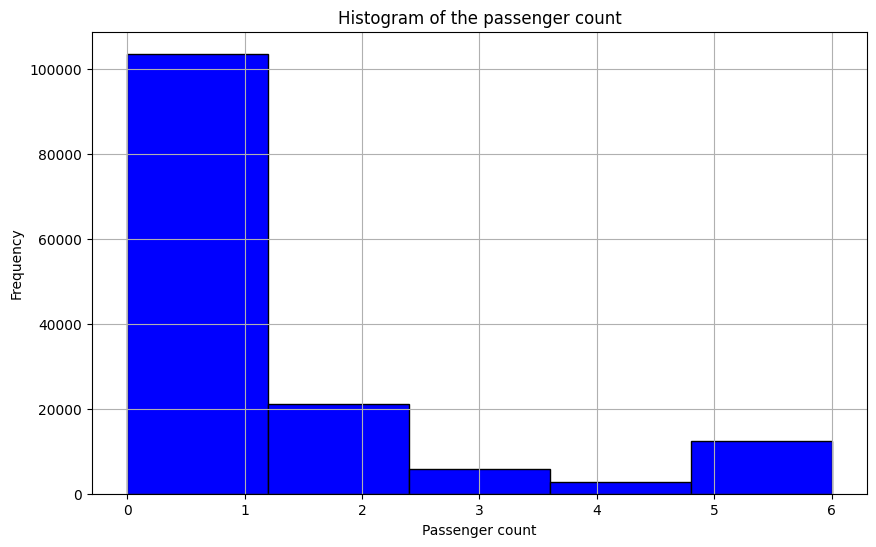

In [16]:
plt.figure(figsize=(10,6))
plt.hist(pdf['passenger_count'], bins=5, color='blue', edgecolor='black')
plt.title("Histogram of the passenger count")
plt.xlabel("Passenger count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The number of passengers is also more skewed to the right, as it is more likely for there to be taxi rides with few riders than with big parties. 